# Neural Ordinary Differential Equations - Part 1 of 3

Zhihan Yang, April 2024

## Table of contents

1. [Initial-value problems, numerical integrators and approximate solutions](#section1)
- Theory
- Example: pendulum under gravity and friction
- Example: system with ODE defined by a neural network (Neural ODE)
  
2. [Two approaches for differentiating through an ODE solver - discretize-then-optimize vs optimize-then-discretize (adjoint differentiation)](#section2)
3. [Implementing custom VJP rule for adjoint differentiation through odeint](#section3)


In [1]:
import jax
import jax.numpy as np
from jax.experimental.ode import odeint  # we will be relying on this solver throughout the tutorial
import optax

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## 1 Initial-value problems, numerical integrators and approximate solutions <a name="section1"></a>


### 1.1 Theory

A dynamical system can be described by

1. its initial state $z(t_0)$ and
2. how that state evolves over time (described by, for example, a first-order ODE) $\frac{d z(t)}{d t} = f(z(t), t, \theta)$.

We assume that $z(t)\in \mathbb{R}^n$ and $\theta \in \mathbb{R}^{|\theta|}$.

In **initial-value problems**, we are interested in the state at some later time $z(t_1)$:

$$z(t_1) = z(t_0) + \int_{t_0}^{t_1} f(z(t), t, \theta) d t.$$

However, the integral generally cannot be evaluated analytically. Hence we resort to numerical integrators to compute an approximate answer. 

`odeint` from JAX is one such tool. We can treat these tools as blackboxes for the purpose of this tutorial.

### 1.2 Example: pendulum under gravity and friction

<center><img src="pendulum_diagram.png" width=40%></center>

Displacement from natural position along the arc:

$$s = l \theta$$

Acceleration along the arc:

$$a = l \ddot{\theta}$$

Gravitational force along the direction of motion:

$$F_g = - m g \sin \theta$$

Frictional force along the direction of motion (where $c_f$ is the coefficient of friction):

$$F_f = - c_f \frac{d s}{d t} = - c_f l \dot{\theta}$$

Putting all forces together using Newton's law:

$$F = m a = m l \ddot{\theta} = - m g \sin \theta - c_f l \dot{\theta}$$

Rearranging:

$$m l \ddot{\theta} + c_f l \dot{\theta} + m g \sin \theta = 0$$

Dividing both sides of the equation by $ml$:

$$\ddot{\theta} +  \underbrace{\frac{c_f}{m}}_{b} \dot{\theta} + \underbrace{\frac{g}{l}}_{c}\sin \theta = 0$$

We can convert this second-order ODE to a first-order one:

\begin{align}
\dot{\theta} &= \omega \\
\dot{\omega} &= - b \dot{\theta} - c \sin \theta
\end{align}

In [445]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

def pend(z, t, b, c):
    theta, omega = z
    dzdt = [omega, -b*omega - c*np.sin(theta)]
    return dzdt

b = 0.5
c = 0

z0 = [np.pi/2, 0.]

ts = np.linspace(0, 20, 201)

In [446]:
thetas, omegas = odeint(pend, z0, ts, b, c)

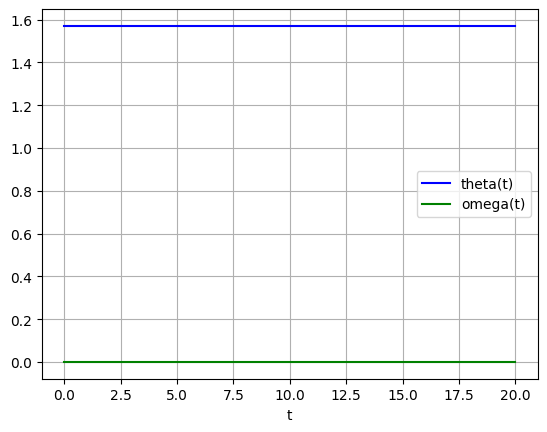

In [447]:
plt.plot(ts, thetas, 'b', label='theta(t)')
plt.plot(ts, omegas, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

Animating the solution (not much math is involved here; safely ignore the code):

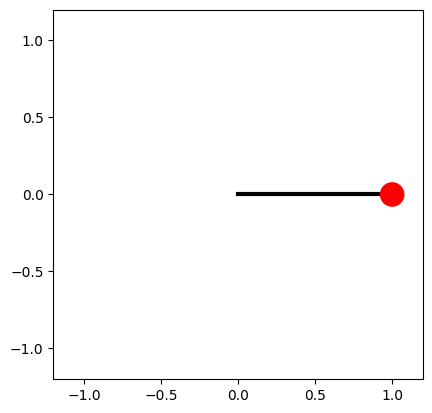

In [253]:
# reference: https://scipython.com/book2/chapter-7-matplotlib/problems/p77/animating-a-pendulum/

dt = 0.1
L = 1

def get_coords(theta):
    return L * np.sin(theta), -L * np.cos(theta)

fig = plt.figure()
ax = fig.add_subplot(aspect='equal')

# add pendulum line
x0, y0 = get_coords(thetas[0])
line, = ax.plot([0, x0], [0, y0], lw=3, c='k')

# add pendulum blob
bob_radius = 0.08
circle = ax.add_patch(plt.Circle(get_coords(thetas[0]), bob_radius,fc='r', zorder=3))

ax.set_xlim(-L*1.2, L*1.2)
ax.set_ylim(-L*1.2, L*1.2)

# rule for updating pendulum line and blob
def animate(i):
    """Update the animation at frame i."""
    x, y = get_coords(thetas[i])
    line.set_data([0, x], [0, y])
    circle.set_center((x, y))

# animation
nframes = len(ts)
duration = nframes * 0.5  # in seconds
ani = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True, interval=duration)

In [254]:
HTML(ani.to_jshtml())

seem like 3 is just the right amount of force to apply

In [2]:
import numpy.random as npr

In [312]:
def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

def mlp(params, inputs):
    for w, b in params:
        outputs = np.dot(inputs, w) + b
        inputs = np.tanh(outputs)
    return outputs

In [428]:
def ode(z, t, b, c, mlp_params):
    theta, omega = z
    x = np.cos(theta)
    y = np.sin(theta)
    z_for_mlp = np.array([x, y, omega])
    dzdt = [omega, -b*omega - c*np.sin(theta) + np.tanh(mlp(mlp_params, z_for_mlp)) * 3]
    return dzdt

In [480]:
def get_solution(z0, b, c, mlp_params):
    start_and_end_times = np.linspace(0, 20, 100)
    res = odeint(controlled_pendulum_dynamics, z0, start_and_end_times, b, c, mlp_params)
    return res[:, 0], res[:, 1]

In [484]:
def loss_fn(z0, b, c, mlp_params):
    thetas, omegas = get_solution(z0, b, c, mlp_params)
    thetas2 = (thetas + np.pi) % (2 * np.pi) - np.pi
    return np.abs(thetas2).mean() + 0.1 * np.mean(np.abs(omegas))

In [485]:
@jax.jit
def update(z0, b, c, mlp_params, opt_state):
    loss, grads = jax.value_and_grad(loss_fn, argnums=3)(z0, b, c, mlp_params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_mlp_params = optax.apply_updates(mlp_params, updates)
    return loss, new_mlp_params, new_opt_state

In [486]:
z0 = np.array([3/4 * np.pi, 0.])
mlp_params = init_random_params(1.0, [3, 500, 1])
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(mlp_params)

b = 0.5
c = 0.

for i in range(1000):
    loss, mlp_params, opt_state = update(z0, b, c, mlp_params, opt_state)
    if i % 50 == 0:
        print(loss)

1.1966394
0.18229343
0.13773605
0.13418421
0.13425347
0.13595283


KeyboardInterrupt: 

In [487]:
res = get_solution(z0, b, c, mlp_params)
thetas = res[0]

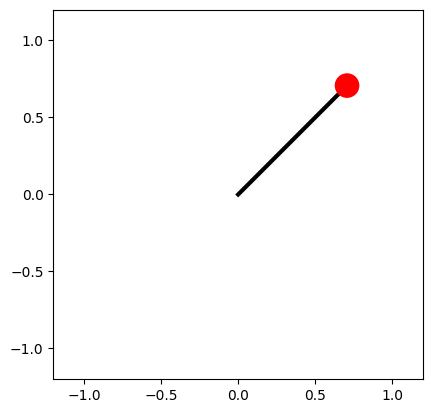

In [488]:
# reference: https://scipython.com/book2/chapter-7-matplotlib/problems/p77/animating-a-pendulum/

dt = 0.1
L = 1

def get_coords(theta):
    return L * np.sin(theta), -L * np.cos(theta)

fig = plt.figure()
ax = fig.add_subplot(aspect='equal')

# add pendulum line
x0, y0 = get_coords(thetas[0])
line, = ax.plot([0, x0], [0, y0], lw=3, c='k')

# add pendulum blob
bob_radius = 0.08
circle = ax.add_patch(plt.Circle(get_coords(thetas[0]), bob_radius,fc='r', zorder=3))

ax.set_xlim(-L*1.2, L*1.2)
ax.set_ylim(-L*1.2, L*1.2)

# rule for updating pendulum line and blob
def animate(i):
    """Update the animation at frame i."""
    x, y = get_coords(thetas[i])
    line.set_data([0, x], [0, y])
    circle.set_center((x, y))

# animation
nframes = len(np.linspace(0, 20, 100))
duration = nframes * 0.2  # in seconds
ani = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True, interval=duration)

In [489]:
HTML(ani.to_jshtml())

### 1.3 Neural ODE

Define the initial state and ODE here (probably meaningless)

In [ ]:
# ODE and initial condition here

In [ ]:
# solve

In [ ]:
# plot

## 2. Two approaches for differentiating through an ODE solver - discretize-then-optimize vs optimize-then-discretize (adjoint differentiation) <a name="section2"></a>

In [26]:
# actually run the two approaches to compare

## 3. Implementing custom VJP rule for adjoint differentiation through odeint <a name="section3"></a>

So what's the actual contribution of neural ODE paper?

In [9]:
def f(A):
    return A ** 2

In [17]:
res, vjpfun = jax.vjp(f, np.array([[1.2, 5.4], [8.7, -1.3]]))